In [1]:
import pytz
from datetime import datetime, timedelta
import os
import geopandas as gpd
import json
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import re
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np

In [6]:
## This notebook is to study the relationship between city-level Heat Exposure & temperature from weather station
## Read result from heat exposure
df = gpd.read_file('./output/census_tract_heat_exposure.shp')
df

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,he_val,geometry
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,0.349523,"POLYGON ((-87.62405 41.73022, -87.62405 41.730..."
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,0.304561,"POLYGON ((-87.68608 41.82296, -87.68607 41.823..."
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,0.254064,"POLYGON ((-87.62935 41.85280, -87.62934 41.852..."
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,0.314189,"POLYGON ((-87.68813 41.85569, -87.68816 41.856..."
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,0.384308,"POLYGON ((-87.63312 41.87449, -87.63306 41.874..."
...,...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,None,17,070400,0.445870,"POLYGON ((-87.65746 41.93258, -87.65722 41.932..."
797,7,7.0,031,17031070500,705,Census Tract 705,None,17,070500,0.399139,"POLYGON ((-87.66349 41.93036, -87.66350 41.930..."
798,13,13.0,031,17031130300,1303,Census Tract 1303,None,17,130300,0.312587,"POLYGON ((-87.71436 41.98300, -87.71472 41.982..."
799,29,29.0,031,17031292200,2922,Census Tract 2922,None,17,292200,0.322456,"POLYGON ((-87.71317 41.85523, -87.71357 41.855..."


In [8]:
## read temperature from NOAA

temp = pd.read_csv("./temp/2896807.csv")
temp

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,TAVG,TMAX,TMIN,TOBS
0,US1ILDP0098,"DOWNERS GROVE 0.9 S, IL US",41.784019,-88.016753,229.5,2021-09-26,NaN,NaN,NaN,NaN
1,US1ILDP0098,"DOWNERS GROVE 0.9 S, IL US",41.784019,-88.016753,229.5,2021-09-27,NaN,NaN,NaN,NaN
2,US1ILCK0306,"OAK FOREST 0.6 N, IL US",41.615500,-87.750700,199.3,2021-09-26,NaN,NaN,NaN,NaN
3,US1ILCK0306,"OAK FOREST 0.6 N, IL US",41.615500,-87.750700,199.3,2021-09-27,NaN,NaN,NaN,NaN
4,US1ILCK0148,"OAK LAWN 1.9 SE, IL US",41.693577,-87.728993,182.3,2021-09-26,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
240,US1ILDP0078,"NAPERVILLE 2.4 SE, IL US",41.741838,-88.116204,216.1,2021-09-27,NaN,NaN,NaN,NaN
241,US1INLK0063,"GARY 4.8 ENE, IN US",41.616955,-87.254631,186.5,2021-09-26,NaN,NaN,NaN,NaN
242,US1INLK0063,"GARY 4.8 ENE, IN US",41.616955,-87.254631,186.5,2021-09-27,NaN,NaN,NaN,NaN
243,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",41.960170,-87.931640,204.8,2021-09-26,66.0,83.0,54.0,NaN


In [22]:
## Filter the data to remove NaN column
valid_temp = temp[temp["TMAX"]> -459]
valid_temp

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,TAVG,TMAX,TMIN,TOBS
10,USC00116616,"PARK FOREST, IL US",41.49470,-87.68020,216.4,2021-09-26,NaN,70.0,49.0,54.0
11,USC00116616,"PARK FOREST, IL US",41.49470,-87.68020,216.4,2021-09-27,NaN,82.0,53.0,63.0
14,USC00115097,"LISLE MORTON ARBORETUM, IL US",41.81270,-88.07270,207.3,2021-09-26,NaN,70.0,48.0,51.0
15,USC00115097,"LISLE MORTON ARBORETUM, IL US",41.81270,-88.07270,207.3,2021-09-27,NaN,83.0,51.0,64.0
25,USC00111550,"CHICAGO NORTHERLY ISLAND, IL US",41.85580,-87.60940,177.7,2021-09-26,NaN,82.0,58.0,70.0
26,USC00111550,"CHICAGO NORTHERLY ISLAND, IL US",41.85580,-87.60940,177.7,2021-09-27,NaN,85.0,63.0,64.0
101,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.73720,-87.77750,189.0,2021-09-26,NaN,84.0,56.0,69.0
102,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.73720,-87.77750,189.0,2021-09-27,NaN,88.0,65.0,65.0
146,USW00004838,"CHICAGO PALWAUKEE AIRPORT, IL US",42.12076,-87.90479,191.6,2021-09-26,NaN,83.0,53.0,NaN
147,USW00004838,"CHICAGO PALWAUKEE AIRPORT, IL US",42.12076,-87.90479,191.6,2021-09-27,NaN,88.0,63.0,NaN


In [29]:
prev = []
curr = []

for index, row in valid_temp.iterrows():
    p = Point(float(row["LONGITUDE"]),float(row["LATITUDE"]))
    mint = row["TMIN"]
    maxt = row["TMAX"]
    if (index%2==0):
        ## previous data
        prev.append([p, mint, maxt])
    else:
        ## current data
        curr.append([p, mint, maxt])
        


In [119]:
minprev = []
maxprev = []
mincurr = []
maxcurr = []

for index, row in df.iterrows():
    geom = row["geometry"]
    cent = geom.centroid
    #print(cent.x)
    ## IDW for 926min
    up = 0
    down = 0
    for ele in prev:
        weather_station_loc = ele[0]
        curr_temp = ele[1]
        ## use p = 1
        d = cent.distance(weather_station_loc)
        down = down + 1/(d)
        up = up + curr_temp/(d)
    minprev.append(up/down)
    
    ## IDW for 926max
    up = 0
    down = 0
    for ele in prev:
        weather_station_loc = ele[0]
        curr_temp = ele[2]
        ## use p = 1
        d = cent.distance(weather_station_loc)
        down = down + 1/(d)
        up = up + curr_temp/(d)
    maxprev.append(up/down)
    
    ## IDW for 927min
    up = 0
    down = 0
    for ele in curr:
        weather_station_loc = ele[0]
        curr_temp = ele[1]
        ## use p = 1
        d = cent.distance(weather_station_loc)
        down = down + 1/(d)
        up = up + curr_temp/(d)
    mincurr.append(up/down)
    
    ## IDW for 926min
    up = 0
    down = 0
    for ele in curr:
        weather_station_loc = ele[0]
        curr_temp = ele[2]
        ## use p = 1
        d = cent.distance(weather_station_loc)
        down = down + 1/(d)
        up = up + curr_temp/(d)
    maxcurr.append(up/down)

In [120]:
df["prevmin"]= minprev
df["prevmax"]= maxprev
df["currmin"]= mincurr
df["currmax"]= maxcurr

In [121]:
df

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,he_val,geometry,926min,926max,927min,927max,prevmin,prevmax,currmin,currmax
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,0.349523,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",59.697716,83.900744,58.970804,84.292138,58.043860,82.642008,58.345484,84.356900
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,0.304561,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",60.072675,84.500898,59.806795,84.453492,58.590494,83.328700,58.881133,84.493972
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,0.254064,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",62.608446,84.897591,58.155033,82.284515,60.389315,83.879644,58.287644,83.310078
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,0.314189,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",60.406663,84.501673,59.412715,84.084608,58.653360,83.306570,58.731676,84.373125
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,0.384308,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",62.631738,84.898384,58.130370,82.258237,60.400059,83.874867,58.253335,83.280829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,None,17,070400,0.445870,"POLYGON ((-87.65746 41.93258, -87.65722 41.932...",60.778894,84.376123,58.618748,83.473548,58.533029,83.097035,58.353604,84.163544
797,7,7.0,031,17031070500,705,Census Tract 705,None,17,070500,0.399139,"POLYGON ((-87.66349 41.93036, -87.66350 41.930...",60.672743,84.354987,58.656772,83.552144,58.483034,83.084471,58.363628,84.195812
798,13,13.0,031,17031130300,1303,Census Tract 1303,None,17,130300,0.312587,"POLYGON ((-87.71436 41.98300, -87.71472 41.982...",58.930876,83.901216,58.722906,84.526722,57.619499,82.786599,58.304389,84.572152
799,29,29.0,031,17031292200,2922,Census Tract 2922,None,17,292200,0.322456,"POLYGON ((-87.71317 41.85523, -87.71357 41.855...",59.141524,84.380294,60.434659,85.236412,58.174552,83.242979,59.008294,84.772445


In [122]:
y = list(df["he_val"])

In [123]:
x1 = list(df['prevmin'])
x2 = list(df['prevmax'])
x3 = list(df['currmin'])
x4 = list(df['currmax'])
X = []
X2 = []
for i in range(0, len(x1)):
    X.append([x1[i], x2[i], x3[i], x4[i]])
    X2.append([x2[i]])

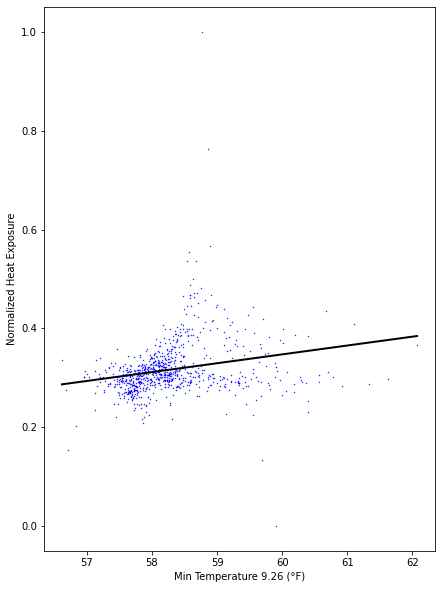

In [193]:
x = x1
y = y
plt.figure(figsize=(7,10))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('Min Temperature 9.26 (°F)')
plt.ylabel('Normalized Heat Exposure')

m, b = np.polyfit(x, y, 1)
mn = min(x)
mx = max(x)
plt.plot([mn, mx],[mn*m+b, mx*m+b], 'k-', lw=2)
plt.show()

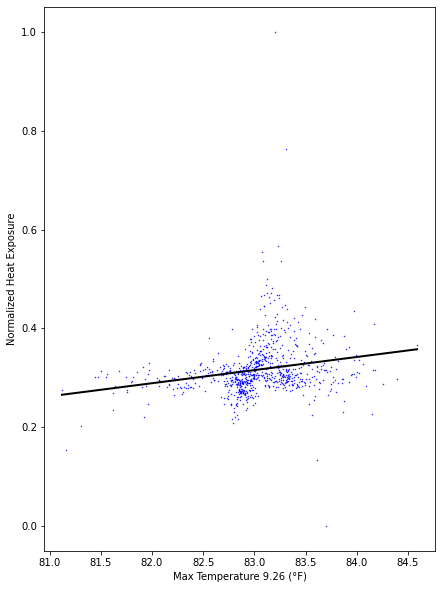

In [194]:
x = x2
y = y
plt.figure(figsize=(7,10))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('Max Temperature 9.26 (°F)' )
plt.ylabel('Normalized Heat Exposure')
m, b = np.polyfit(x, y, 1)
mn = min(x)
mx = max(x)
plt.plot([mn, mx],[mn*m+b, mx*m+b], 'k-', lw=2)
plt.show()

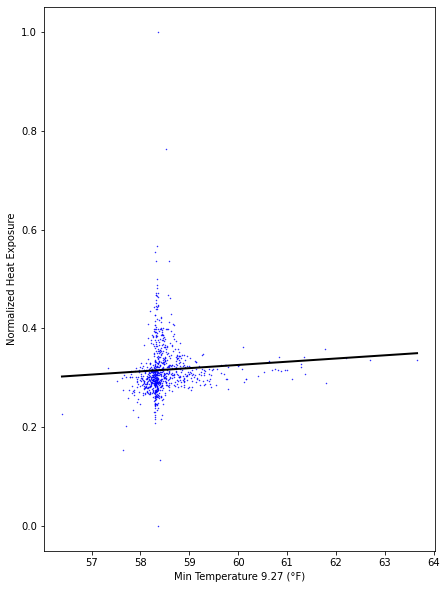

In [196]:
x = x3
y = y
plt.figure(figsize=(7,10))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('Min Temperature 9.27 (°F)')
plt.ylabel('Normalized Heat Exposure')
m, b = np.polyfit(x, y, 1)
mn = min(x)
mx = max(x)
plt.plot([mn, mx],[mn*m+b, mx*m+b], 'k-', lw=2)
plt.show()

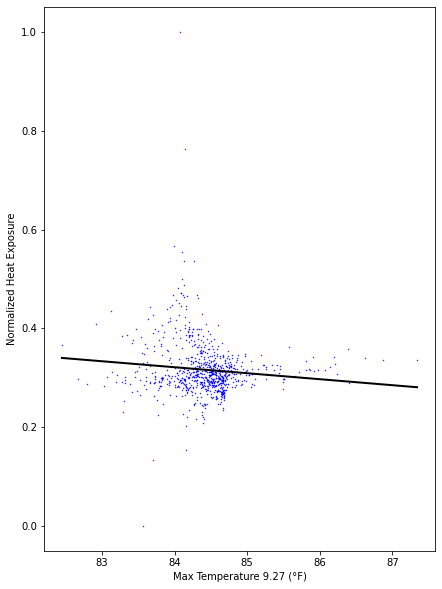

In [197]:
x = x4
y = y
plt.figure(figsize=(7, 10))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('Max Temperature 9.27 (°F)')
plt.ylabel('Normalized Heat Exposure')
m, b = np.polyfit(x, y, 1)
mn = min(x)
mx = max(x)
plt.plot([mn, mx],[mn*m+b, mx*m+b], 'k-', lw=2)
plt.show()

In [166]:
df["926min"] = df["prevmin"]
df["926max"] = df["prevmax"]
df["927min"] = df["currmin"]
df["927max"] = df["currmax"]

In [169]:
## ANOVA test
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('he_val~prevmin+prevmax+currmin+currmax', data=df).fit()


In [172]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 he_val   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     14.92
Date:                Mon, 07 Mar 2022   Prob (F-statistic):           9.14e-12
Time:                        02:22:06   Log-Likelihood:                 1190.4
No. Observations:                 801   AIC:                            -2371.
Df Residuals:                     796   BIC:                            -2347.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6200      1.636      2.212      0.027       0.408       6.832
prevmin       -0.0420      0.019     -2.223      0.027      -0.079      -0.005
prevmax        0.0515      0.017      3.007      0.003       0.018       0.085
currmin        0.0340      0.010      3.262      0.001       0.014       0.054
currmax       -0.0843      0.027     -3.163      0.002      -0.137      -0.032
==============================================================================
Omnibus:                      657.105   Durbin-Watson:                   1.450
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43775.080
Skew:                           3.189   Prob(JB):                         0.00
Kurtosis:                      38.650   Cond. No.                     1.22e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [131]:
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
prevmin,0.014902,1.0,4.941059,0.026506
prevmax,0.027262,1.0,9.039281,0.002725
currmin,0.032098,1.0,10.642495,0.001152
currmax,0.030182,1.0,10.007363,0.001618
Residual,2.400723,796.0,NaN,NaN


In [137]:
with open('./output/city_analysis.json', 'w') as f:
        f.write(df.to_json())

In [190]:
print(min(x1),max(x1))
print(min(x2),max(x2))
print(min(x3),max(x3))
print(min(x4),max(x4))

56.61733093149059 62.070998832778066
81.12081314668825 84.5882158593384
56.395535052398046 63.65808921700676
82.44932164174445 87.33968220510928
